In [1]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install formulaic

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix


In [4]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=2024):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)


X, y = generar_datos()

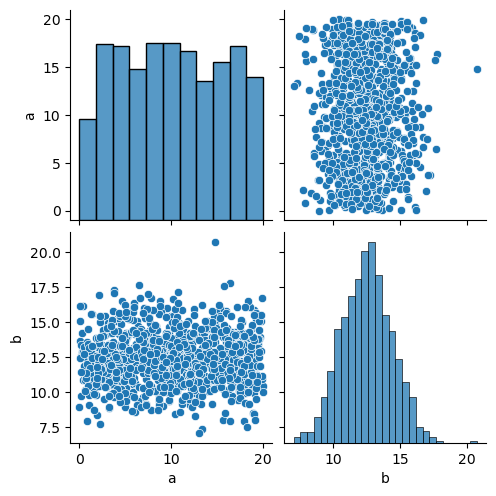

In [5]:
sns.pairplot(X)

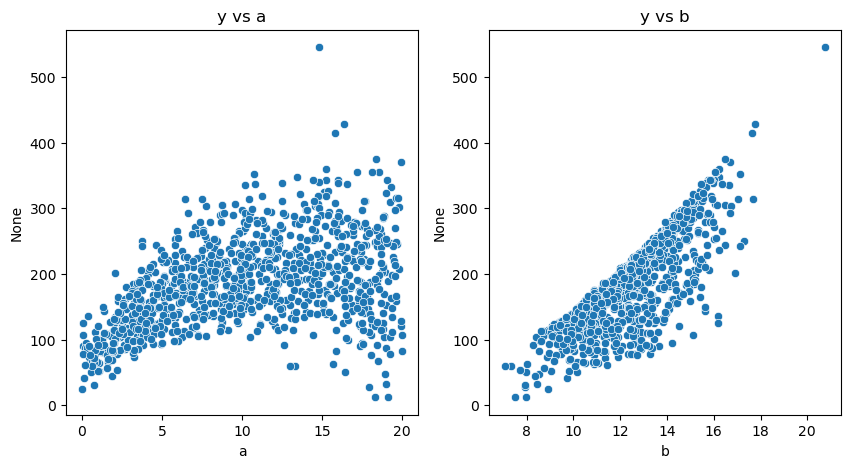

In [6]:
fig, axs= plt.subplots(1, 2, figsize = (10, 5))
for i, col in enumerate(X):
    sns.scatterplot(x=X[col], y=y, ax=axs[i])
    axs[i].set_title(f"y vs {col}")

In [7]:
test_split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [8]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)


LinearRegression()

In [9]:
lr1.intercept_
beta1 = pd.Series(lr1.coef_, index=X_train.columns)
beta1["intercept"] = lr1.intercept_
beta1

a              5.625882
b             28.054812
intercept   -222.000189
dtype: float64

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [11]:
y_pred = lr1.predict(X_test)
print(
    "# RMSE",
    f"Train: {rmse(lr1.predict(X_train), y_train):.4f}",
    "Test:  %.4f" % rmse(y_pred, y_test),
    sep="\n",
)

# RMSE
Train: 26.4619
Test:  28.3876


In [12]:
df_test = pd.concat(
    [
        X_test,
        y_test.rename("y"),
        pd.Series(y_pred, name="y_pred", index=y_test.index),
    ],
    axis=1,
)
df_test.head()

,a,b,y,y_pred
945,11.788097,15.111320,294.504866,268.263479
794,12.712614,11.884333,197.336893,182.932185
946,0.165232,11.440478,61.383078,99.889832
993,14.631676,13.923646,279.389867,250.941150
159,9.197219,13.880550,238.595650,219.158502


In [13]:
#Otra forma de hacerlo

df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"]
df_test.head()

,a,b,y,y_pred,resid
945,11.788097,15.111320,294.504866,268.263479,26.241387
794,12.712614,11.884333,197.336893,182.932185,14.404708
946,0.165232,11.440478,61.383078,99.889832,-38.506754
993,14.631676,13.923646,279.389867,250.941150,28.448717
159,9.197219,13.880550,238.595650,219.158502,19.437148


### Análisis de residuos

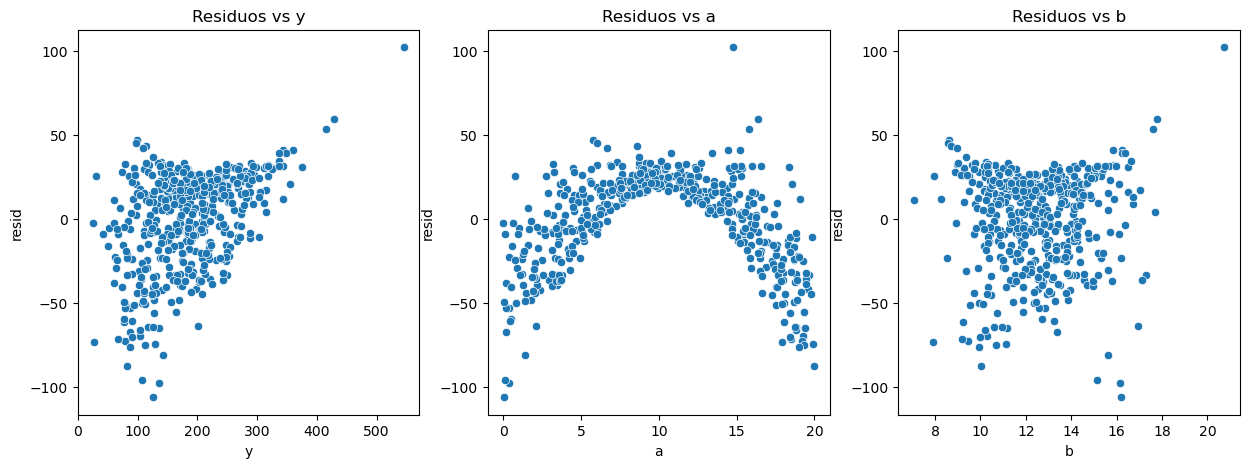

In [14]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

Pareciera haber alguna relación cuadrática entre los residuos y $a$, entonces...

In [15]:
formula = "~ poly(a, 2, raw=True) * b"
# Como solo tiene RHS, no devuelve $y$
X_train2 = model_matrix(formula, data=X_train)
X_train2.head()
# pueden explicar por qué quedan las columnas que quedas?

,Intercept,"poly(a, 2, raw=True)[0]","poly(a, 2, raw=True)[1]",b,"poly(a, 2, raw=True)[0]:b","poly(a, 2, raw=True)[1]:b"
816,1.0,0.886459,0.785810,13.425392,11.901065,10.549810
465,1.0,11.300314,127.697090,14.502627,163.884238,1851.943304
109,1.0,2.798665,7.832525,10.982316,30.735822,86.019265
295,1.0,17.280935,298.630710,11.063778,191.192432,3303.983962
998,1.0,13.226307,174.935187,14.507008,191.874130,2537.786080


In [16]:
import re


def nombres_poli(s):
    repl = lambda m: f"{m.group(1)}^{int(m.group(2))+1}"
    nombres = re.sub(r"poly\((\w), \d+, raw=True\)\[(\d)\]", repl, s).replace("^1", "") # Regex
    return nombres

np.vectorize(nombres_poli)(X_train2.columns)

array(['Intercept', 'a', 'a^2', 'b', 'a:b', 'a^2:b'], dtype='<U9')

### np.vectorize

In [17]:
assert all(
    np.vectorize(nombres_poli)(X_train2.columns)
    == [nombres_poli(c) for c in X_train2.columns]
)

In [18]:
lr2 = LinearRegression(fit_intercept=False)  # Ya está incluido en model_matrix
lr2.fit(X_train2, y_train)


LinearRegression(fit_intercept=False)

In [19]:
def betas(lr, train):
    beta = pd.Series(lr.coef_, index=train.columns)
    if lr.fit_intercept:
        beta["Intercept"] = lr.intercept_
    beta.index = beta.index.map(nombres_poli)
    return beta


betas(lr2, X_train2)

Intercept   -81.003109
a             1.158016
a^2          -0.708357
b            12.191623
a:b           1.648849
a^2:b        -0.007244
dtype: float64

In [20]:
def mostrar_rmse(lr, X_train, y_train, X_test, y_test):
    print(
        "# RMSE",
        f"Train: {rmse(lr.predict(X_train), y_train):.4f}",
        "Test:  %.4f" % rmse(lr.predict(X_test), y_test),
        sep="\n",
    )


mostrar_rmse(lr2, X_train2, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 4.8640
Test:  5.4504


In [21]:
y_pred2 = lr2.predict(model_matrix(formula, data=X_test))
df_test = df_test.rename(columns={"y_pred": "y_pred1", "resid": "resid1"})
df_test["y_pred2"] = y_pred2
df_test["resid2"] = df_test["y"] - df_test["y_pred2"]

Text(0.5, 1.0, "92.40% de las observaciones 'ajustan mejor' con lr2")

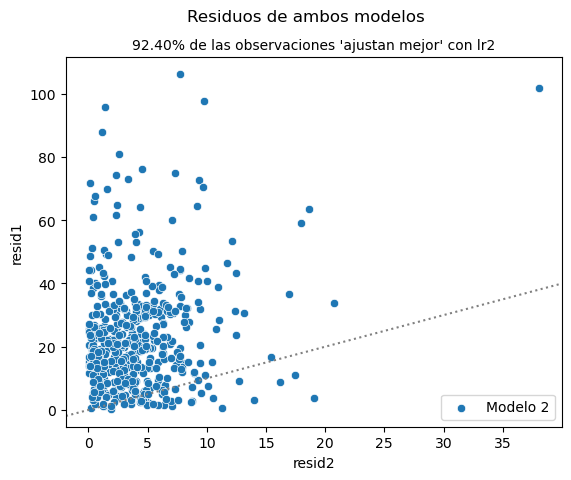

In [22]:
sns.scatterplot(x="resid2", y="resid1", data=df_test.abs(), label="Modelo 2")
plt.axline((0, 0), slope=1, color="gray", linestyle="dotted")
plt.suptitle(f"Residuos de ambos modelos")
perc_mejora = 100 * (df_test.resid2.abs() < df_test.resid1.abs()).mean()
plt.title(f"{perc_mejora:.2f}% de las observaciones 'ajustan mejor' con lr2", fontsize=10)

In [23]:
# Otra manera de calcular RMSE Test
df_test[["resid1", "resid2"]].pow(2).mean().apply(np.sqrt)

resid1    28.387585
resid2     5.450421
dtype: float64

Revisamos otra vez la estructura de los residuos

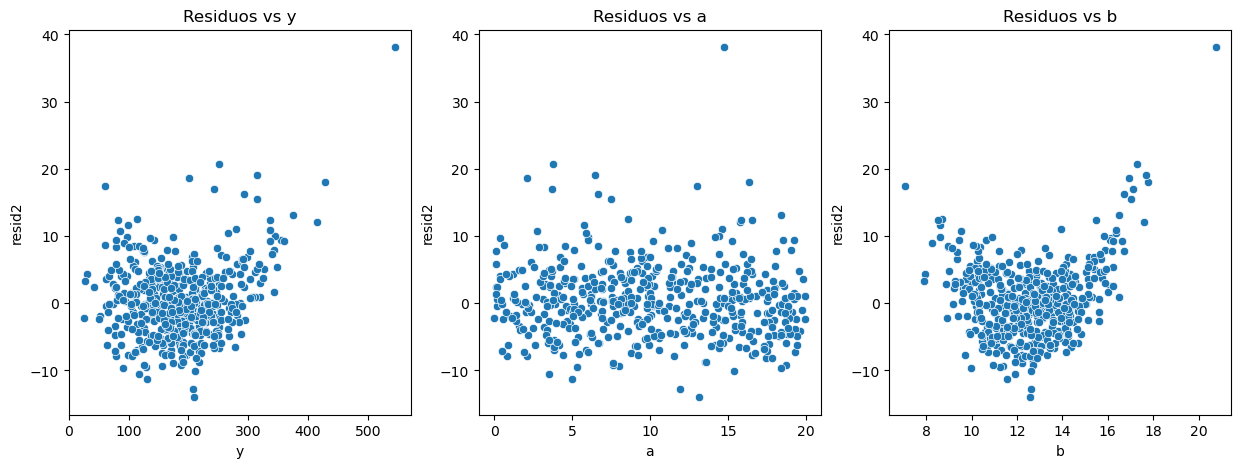

In [24]:
fig, axs= plt.subplots(1, 3, figsize = (15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid2", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

$y \sim a$ parece bien capturado, pero aún queda una estructura contra $b$. Será cuadrática también?

In [25]:
formula = "~ 0 + poly(a, 2, raw=True) * poly(b, 2, raw=True)"
X_train3 = model_matrix(formula, data=X_train)
X_train3.shape, np.vectorize(nombres_poli)(X_train3.columns)

((500, 8),
 array(['a', 'a^2', 'b', 'b^2', 'a:b', 'a^2:b', 'a:b^2', 'a^2:b^2'],
       dtype='<U7'))

¿Por qué hay 8 terminos y no $3 \times 3=9$? ¿Se acabará algún día este proceso?

0 + : nos saca el intersect

## Regrsión Grieta (AKA Ridge)

Una hipótesis: si le doy suficientes grados de libertad al modelo, y regularizo fuertemente, debería encontrar un modelo simple que ajuste a los datos sin demasiado esfuerzo. Será verdad?

In [26]:
from sklearn.linear_model import Ridge
formula = "~ 0 + poly(a, 3, raw=True) * poly(b, 3, raw=True)"
X_train4 = model_matrix(formula, data=X_train)

lr4 = Ridge(alpha=100)
lr4.fit(X_train4, y_train)

Ridge(alpha=100)

In [27]:
lr4.coef_

array([ 2.29253648e-02, -3.31803537e-02, -3.98273491e-02,  8.05865229e-03,
        2.20980321e-02,  2.64523772e-02,  1.40918425e-01,  2.79047556e-02,
        3.44998446e-03,  2.92298529e-01, -2.18984194e-02,  3.16772887e-04,
       -1.28721366e-02,  1.14870019e-03, -2.60161346e-05])

In [28]:
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 4.1769
Test:  4.1800


In [29]:
pd.DataFrame({"lr2": betas(lr2, X_train2), "lr4": betas(lr4, X_train4)}).round(4)

,lr2,lr4
Intercept,-81.0031,13.2460
a,1.1580,0.0229
a:b,1.6488,0.1409
a:b^2,NaN,0.2923
a:b^3,NaN,-0.0129
a^2,-0.7084,-0.0332
a^2:b,-0.0072,0.0279
a^2:b^2,NaN,-0.0219
a^2:b^3,NaN,0.0011
a^3,NaN,-0.0398


Nada mal! Pero se podrá mejorar aún más? Cómo encunetro el valor óptimo de la penalización $\alpha$? CV al rescate

## Validación cruzada con scikit-learn
### np.logspace

In [30]:
np.logspace(0, 2, 5)

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [31]:
alfas = np.logspace(-3, 3, 61)

In [32]:
alfas[:5].round(3), alfas[-5:].round(3)

(array([0.001, 0.001, 0.002, 0.002, 0.003]),
 array([ 398.107,  501.187,  630.957,  794.328, 1000.   ]))

In [33]:
def norma(vec):
    return np.sqrt((vec ** 2).sum())

In [34]:
assert norma(np.array([3, 4])) == 5

In [35]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


rmse_train = {}
rmse_test = {}
beta_norm = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] = rmse(ridge.predict(X_train4), y_train)
    rmse_test[alfa] = rmse(ridge.predict(model_matrix(formula, X_test)), y_test)
    beta_norm[alfa] = norma(ridge.coef_)
    intercept[alfa] = ridge.intercept_

    logger.info(f"Alfa: {alfa.round(3):.3f}")

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.14303e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.24839e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.38114e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 0.002
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.54844e-19): result may not be accurate.
  return linalg.solve(A, 

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.35934e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 1.259
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.99167e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 1.585
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00528e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
INFO:__main__:Alfa: 1.995
INFO:__main__:Alfa: 2.512
INFO:__main__:Alfa: 3.162
INFO:__main__:Alfa: 3.981
INFO:__main__:Alfa: 5.012
INFO:__main__:Alfa: 6.310
INFO:__main__:Alfa: 7.943
INFO:__main__:Alfa: 10.000
INFO:__main__:Alfa:

Fíjense qué interesante: efecivamente para alfas muy pequeños, cuando Ridge es casi igual a la reg. lineal "vainilla", la matrix efectivamente está mal condicionada.

In [36]:
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "beta_norm": beta_norm,
        "intercept": intercept,
    }
).reset_index(names="alfa")

In [37]:
data

,alfa,rmse_train,rmse_test,beta_norm,intercept
0,0.001000,4.173566,4.146711,38.132789,-72.520042
1,0.001259,4.173628,4.144228,34.940078,-66.464811
2,0.001585,4.173704,4.141723,31.611669,-60.143607
3,0.001995,4.173790,4.139269,28.231059,-53.711348
4,0.002512,4.173885,4.136934,24.887270,-47.332970
...,...,...,...,...,...
56,398.107171,4.177326,4.177849,0.316762,13.975092
57,501.187234,4.177405,4.176075,0.315599,14.067639
58,630.957344,4.177505,4.173771,0.314426,14.167422
59,794.328235,4.177641,4.170867,0.313146,14.281581


### Interludio: $\alpha \rightarrow \infty$? 

In [38]:
ridge = Ridge(alpha=1e100)
ridge.fit(X_train4, y_train)
ridge.intercept_

185.712557987755

### np.isclose

In [39]:
assert np.isclose(y_train.mean(), ridge.intercept_)

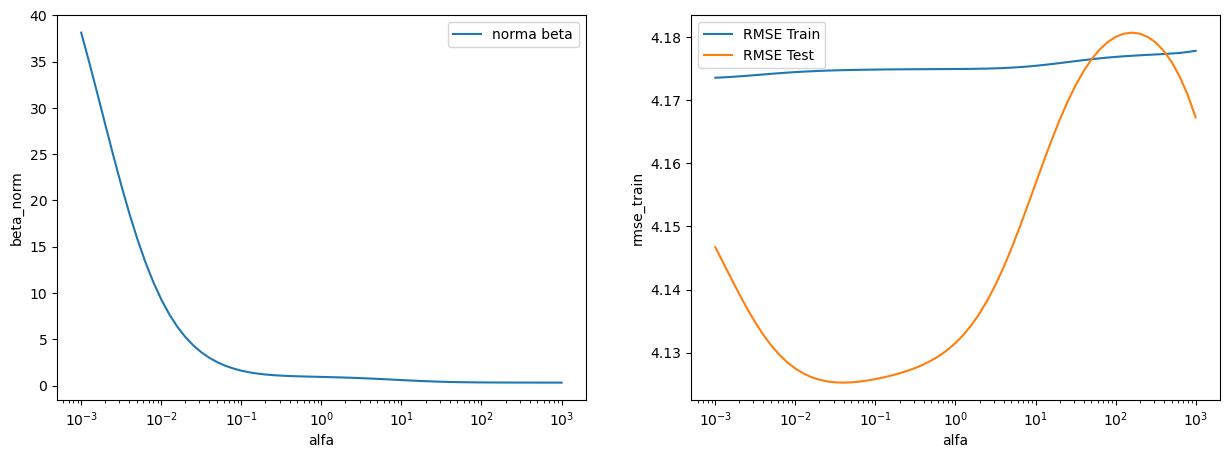

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.lineplot(data=data, x="alfa", y="beta_norm", label="norma beta", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept")
sns.lineplot(data=data, x="alfa", y="rmse_train", label="RMSE Train", ax=axs[1])
sns.lineplot(data=data, x="alfa", y="rmse_test", label="RMSE Test", ax=axs[1])
plt.xscale("log")  # Probar comentando esta línea
plt.legend()

In [41]:
optimo = data.iloc[data.rmse_test.idxmin()]
optimo

alfa          0.039811
rmse_train    4.174773
rmse_test     4.125246
beta_norm     2.998271
intercept    -2.903671
Name: 16, dtype: float64

In [42]:
lr4 = Ridge(alpha=optimo.alfa)
lr4.fit(X_train4, y_train)
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 4.1748
Test:  4.1252


/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.74759e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [43]:
betas(lr4, X_train4).abs().sort_values(ascending=False)

Intercept    2.903671
b            2.283448
a            1.862634
a:b          0.485267
a:b^2        0.203970
a^2          0.158632
a^3          0.035109
b^2          0.030877
a^2:b        0.028748
b^3          0.024556
a^2:b^2      0.010699
a:b^3        0.009026
a^3:b        0.004958
a^2:b^3      0.000688
a^3:b^3      0.000012
a^3:b^2      0.000007
dtype: float64

Para reflexionar: ¿Qué es más importante, $$0.000012\ a^3:b^3$$ o $$0.485267\ a:b$$? ¿De qué depende?

### Una vez más, con ~~sentimiento~~ `GridSearchCV`

In [44]:
from sklearn.model_selection import GridSearchCV

# param_grid = {"alpha": alfas}
mas_alfas = np.unique(np.concatenate([alfas, np.logspace(-4, 4, 41)]))
param_grid = {"alpha": mas_alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.67713e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.94808e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.89361e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.64877e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.20458e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.22887e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.08568e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.44562e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.34547e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.31193e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.64746e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.6033e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/s

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.84651e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.90749e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.82235e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.30479e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/miniconda3/envs/alc/lib/python3.10/

{'alpha': 1584.893192461114}

Obtengo el mejor modelo que minimice el score:
- alpha = 1584.893

In [45]:
cv_results_ = pd.DataFrame(gs.cv_results_)[
    ["param_alpha", "mean_test_score", "mean_train_score"]
]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

In [46]:
cv_results_.head()

,param_alpha,mean_test_score,mean_train_score
0,0.0001,4.312377,4.156141
1,0.000158,4.311271,4.156163
2,0.000251,4.309698,4.156211
3,0.000398,4.307571,4.156307
4,0.000631,4.304887,4.156487


In [47]:
cv_results_.dtypes

param_alpha          object
mean_test_score     float64
mean_train_score    float64
dtype: object

In [48]:
cv_results_["param_alpha"] = cv_results_["param_alpha"].astype(float)

In [49]:
cv_results_.set_index("param_alpha").loc[[optimo.alfa, gs.best_params_["alpha"]]]

,mean_test_score,mean_train_score
param_alpha,,
0.039811,4.285365,4.159901
1584.893192,4.220708,4.169354


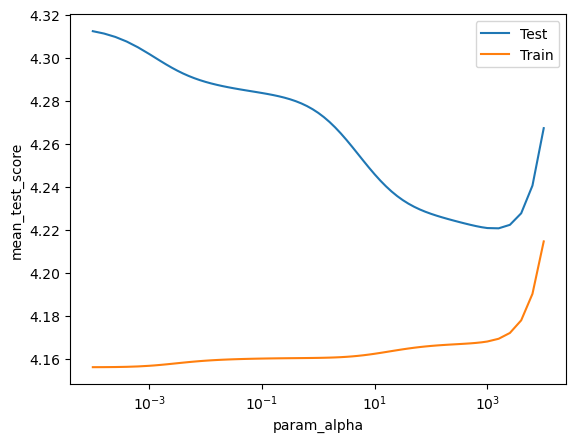

In [50]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [51]:
mejor = gs.best_estimator_
mostrar_rmse(mejor, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 4.1786
Test:  4.1580


In [52]:
formula_real = "~ poly(a, 2, raw=True) + poly(b, 2, raw=True) + a:b"
X_real = model_matrix(formula_real, data=X_train)
lr_real = LinearRegression()
lr_real.fit(X_real, y_train)
mostrar_rmse(lr_real, X_real, y_train, model_matrix(formula_real, X_test), y_test)


# RMSE
Train: 4.1979
Test:  4.0513


In [53]:
betas(lr_real, X_real).round(3)

Intercept   -0.489
a            2.978
a^2         -0.801
b           -1.659
b^2          0.581
a:b          1.504
dtype: float64

Los coeficientes originales eran:
$$ z = 1 + 3x - 2y + 1.5 xy - 0.8 x^2 - 0.6 y^2 + \epsilon$$

Entonces, ¿es cierta la hipótesis? ¿Da lo mismo un modelo "genérico" con regularización que un modelo "ad-hoc"? ¿En qué tipo de tareas?

## Consigna

Cargue el dataset `wine` de scikit-learn, e intente predecir el contenido de alcohol (`alcohol`) de cada vino, usando las características a su disposición, usando una regresión Ridge sobre una matriz de diseño sesudamente construida.

NOTA: El dataset está preparado para utilizarlo en problemas de clasificación, así que tendrá que trocar el objetivo ("target") con la variable predictora "alcohol". Note que la etiqueta del vino peude ser de utilidad en el diseño del modelo.

In [54]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [55]:
dir(wine)  # estos son los atributos del objeto, exprorelos!

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [57]:
wine.data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


Vamos a dividir nuestra base de datos en 20-80, como hacemos siempre

Necesitamos obtener el alpha mas optimo para nuestro modelo. 

Esto se obtiene usando Grid Search de nuestra base de datos.

In [60]:
test_split = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [62]:
alphas = np.logspace(-3, 3, 61)
alphas

array([1.00000000e-03, 1.25892541e-03, 1.58489319e-03, 1.99526231e-03,
       2.51188643e-03, 3.16227766e-03, 3.98107171e-03, 5.01187234e-03,
       6.30957344e-03, 7.94328235e-03, 1.00000000e-02, 1.25892541e-02,
       1.58489319e-02, 1.99526231e-02, 2.51188643e-02, 3.16227766e-02,
       3.98107171e-02, 5.01187234e-02, 6.30957344e-02, 7.94328235e-02,
       1.00000000e-01, 1.25892541e-01, 1.58489319e-01, 1.99526231e-01,
       2.51188643e-01, 3.16227766e-01, 3.98107171e-01, 5.01187234e-01,
       6.30957344e-01, 7.94328235e-01, 1.00000000e+00, 1.25892541e+00,
       1.58489319e+00, 1.99526231e+00, 2.51188643e+00, 3.16227766e+00,
       3.98107171e+00, 5.01187234e+00, 6.30957344e+00, 7.94328235e+00,
       1.00000000e+01, 1.25892541e+01, 1.58489319e+01, 1.99526231e+01,
       2.51188643e+01, 3.16227766e+01, 3.98107171e+01, 5.01187234e+01,
       6.30957344e+01, 7.94328235e+01, 1.00000000e+02, 1.25892541e+02,
       1.58489319e+02, 1.99526231e+02, 2.51188643e+02, 3.16227766e+02,
      

--------
Ahora usamos el GridSearchCV

In [64]:
mas_alphas = np.unique(np.concatenate([alphas, np.logspace(-4, 4, 41)]))
param_grid = {"alpha": mas_alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,    # Entrenamiento cruzado partido en 4 train ,1 test
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train, y_train)

gs.best_params_

{'alpha': 6.309573444801936}

Obtuvimos alpha = 6.309 como el mejor modelo que minimiza el score.

In [66]:
cv_results_ = pd.DataFrame(gs.cv_results_)[
    ["param_alpha", "mean_test_score", "mean_train_score"]
]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

In [67]:
cv_results_.head()

,param_alpha,mean_test_score,mean_train_score
0,0.0001,27.416572,27.17569
1,0.000158,27.416572,27.17569
2,0.000251,27.416572,27.17569
3,0.000398,27.416572,27.17569
4,0.000631,27.416572,27.17569


Aca podemos ver los diferentes valores de Beta en train y luego en test dados estos valores de alphas.

Nos quedaremos siempre con el que tenga menor "mean_test_score"

Una vez que obtuvimos el elpha mas optimo, necesitamos obtener los Betas mas optimos

Para eso usamos Ridge (Regresion Grieta)

In [75]:
X_train

,"poly(a, 3, raw=True)[0]","poly(a, 3, raw=True)[1]","poly(a, 3, raw=True)[2]","poly(b, 3, raw=True)[0]","poly(b, 3, raw=True)[1]","poly(b, 3, raw=True)[2]","poly(a, 3, raw=True)[0]:poly(b, 3, raw=True)[0]","poly(a, 3, raw=True)[1]:poly(b, 3, raw=True)[0]","poly(a, 3, raw=True)[2]:poly(b, 3, raw=True)[0]","poly(a, 3, raw=True)[0]:poly(b, 3, raw=True)[1]","poly(a, 3, raw=True)[1]:poly(b, 3, raw=True)[1]","poly(a, 3, raw=True)[2]:poly(b, 3, raw=True)[1]","poly(a, 3, raw=True)[0]:poly(b, 3, raw=True)[2]","poly(a, 3, raw=True)[1]:poly(b, 3, raw=True)[2]","poly(a, 3, raw=True)[2]:poly(b, 3, raw=True)[2]"
607,9.953327,99.068710,986.063227,9.917892,98.364583,975.569312,98.716019,982.552773,9779.668635,979.054816,9744.852327,9.699370e+04,9710.159968,9.664839e+04,9.619730e+05
768,18.395041,338.377544,6224.468903,9.989067,99.781464,996.723756,183.749304,3380.076043,62176.638395,1835.484156,33763.806860,6.210866e+05,18334.774654,3.372689e+05,6.204076e+06
822,4.154432,17.259307,71.702623,14.337907,205.575581,2947.523581,59.565864,247.462345,1028.065547,854.049822,3548.092121,1.474031e+04,12245.287020,5.087222e+04,2.113452e+05
518,7.590989,57.623116,437.416448,12.781738,163.372820,2088.188541,97.026032,736.523558,5590.942330,1240.161302,9414.050970,7.146196e+04,15851.416530,1.203279e+05,9.134080e+05
837,19.763128,390.581221,7719.106589,15.544834,241.641876,3756.282949,307.214549,6071.520395,119992.233577,4775.599285,94380.779049,1.865259e+06,74235.900011,1.467134e+06,2.899515e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,4.063746,16.514030,67.108823,12.370095,153.019247,1892.862603,50.268922,204.280124,830.142508,621.831333,2526.964510,1.026894e+04,7692.112582,3.125879e+04,1.270278e+05
779,15.736679,247.643061,3897.079321,14.378677,206.746350,2972.738962,226.272621,3560.779564,56034.844438,3253.500906,51199.298878,8.057069e+05,46781.038332,7.361782e+05,1.158500e+07
452,14.280828,203.942045,2912.461238,12.192571,148.658789,1812.532851,174.120009,2486.577874,35510.390615,2122.970580,30317.777437,4.329630e+05,25884.469667,3.696517e+05,5.278932e+06
422,3.609588,13.029124,47.029768,14.361524,206.253383,2962.112995,51.839184,187.118086,675.419164,744.489700,2687.300955,9.700049e+03,10692.006993,3.859374e+04,1.393075e+05


In [73]:
formula_real2 = "~ poly(a, 2, raw=True) + poly(b, 2, raw=True) + a:b"
X_real = model_matrix(formula_real, data=X_train)
lr_real2 = LinearRegression()
lr_real2.fit(X_real, y_train)
mostrar_rmse(lr_real2, X_real, y_train, model_matrix(formula_real2, X_test), y_test)


FactorEvaluationError: Unable to evaluate factor `a`. [NameError: `a` is not present in the dataset or evaluation context.]